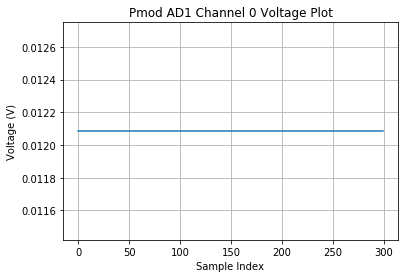

In [3]:
import pynq
from pynq import Overlay
from pynq import MMIO
import time
from operator import*
import matplotlib.pyplot as plt

# Load the SPI overlay
ol = Overlay("spi.bit")
spi = ol.axi_quad_spi_0

# Initialize SPI with correct phase/polarity for the ADC (Pmod AD1)
def init(spi, phase=1, polarity=1):
    spi.write(0x40, 0x0a)  # Enable SPI
    spi.write(0x28, 0x04)  # Configure FIFO reset
    spi.write(0x1c, 0x00)  # Disable chip select
    spi.write(0x70, 0xFFFFFFFF)  # Clear interrupt flags
    ctrlreg = spi.read(0x60)  # Control register read
    ctrlreg |= 0xe6  # Enable SPI, master mode, manual slave select
    spi.write(0x60, ctrlreg)  # Write control register
    ctrlreg = spi.read(0x60)  # Read control again
    ctrlreg &= ~(0x18)  # Clear CPHA and CPOL
    if phase == 1:
        ctrlreg |= 0x10  # Set CPHA if needed
    if polarity == 1:
        ctrlreg |= 0x08  # Set CPOL if needed
    spi.write(0x60, ctrlreg)  # Write back control register

# Function to transfer data over SPI
def transfer(packet, spi):
    recvData = []
    for data in packet:
        spi.write(0x68, data)  # Write data to TX FIFO
        spi.write(0x70, 0xFFFFFFFE)  # Set transaction length
        ctrlreg = spi.read(0x60)  # Read control register
        ctrlreg &= ~(0x100)  # Clear manual slave select
        spi.write(0x60, ctrlreg)  # Update control register
        statReg = spi.read(0x64)  # Read status register
        while (statReg & 0x04) == 0:  # Wait for transfer to complete
            statReg = spi.read(0x64)  # Recheck status
        ctrlreg = spi.read(0x60)  # Re-read control register
        ctrlreg |= 0x100  # Set manual slave select
        spi.write(0x60, ctrlreg)  # Update control register
    spi.write(0x70, 0xFFFFFFFF)  # Clear interrupt flags
    RxFifoStatus = spi.read(0x64) & 0x01  # Check RX FIFO status
    while RxFifoStatus == 0:
        temp = spi.read(0x6c)  # Read received data
        recvData.append(temp)  # Append to received data list
        RxFifoStatus = spi.read(0x64) & 0x01  # Recheck FIFO status
    return recvData

# Initialize SPI for the ADC
init(spi, phase=0, polarity=0)

# Collect data from Channel 0
values_channel_0 = []
for i in range(300):
    recvData = transfer([0], spi)  # Send dummy data, receive ADC data
    values_channel_0.append(recvData[0])  # Append received value
    time.sleep(0.005)  # Short delay

# Assuming 12-bit ADC with 3.3V reference voltage
V_ref = 3.3
resolution = 4096  # 12-bit resolution
scaled_values = [value * V_ref / resolution for value in values_channel_0]

# Plot the scaled values (in Volts)
plt.plot(scaled_values)
plt.title('Pmod AD1 Channel 0 Voltage Plot')
plt.xlabel('Sample Index')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()
